In [1]:
!nvidia-smi

Sun Jul 21 02:45:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    28W / 300W |     10MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# params

In [2]:
p_o = '.'
SEED = 111

BS = 40
SZ = 512
FP16 = True
DO_UPSAMPLE = False

In [3]:
# get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

from fastai.vision import *
params_tfms = dict(     
    max_lighting=0.1,
    max_warp=0,
    max_rotate=0,
    max_zoom=0,)

resize_method = ResizeMethod.PAD
padding_mode = 'zeros'

# setup

In [4]:
from fastai.vision import *
from torchvision.models.resnet import ResNet, Bottleneck
import cv2

import random 
import numpy as np
import torch
import os


def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

In [5]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, _ = crop_margin(image)

    image = center_crop(image)

    image = cv2.resize(image, (640, 480))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_yz

# prep

In [17]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [18]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [19]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv').sample(10000)
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

# test=pd.read_csv(pp/'retinopathy_solution.csv')
# img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
# img2grd += img2grd_diab_test
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())


13662

[(0, 9164), (2, 2515), (1, 1046), (4, 496), (3, 441)]

In [20]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

# test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
# img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
# img2grd += img2grd_idrid_test
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())

14075

[(0, 9298), (2, 2651), (1, 1066), (4, 545), (3, 515)]

In [21]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [22]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']

df.shape

(14075, 3)

In [23]:
# use competition data as val
df['is_val'] = df.src=='blnd'

In [24]:
df.src.value_counts()

diab     10000
blnd      3662
idrid      413
Name: src, dtype: int64

In [25]:
df.is_val.value_counts()

False    10413
True      3662
Name: is_val, dtype: int64

In [26]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz, 
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 21.1 s, sys: 1.62 s, total: 22.7 s
Wall time: 16.1 s


CPU times: user 896 ms, sys: 871 ms, total: 1.77 s
Wall time: 1min 1s


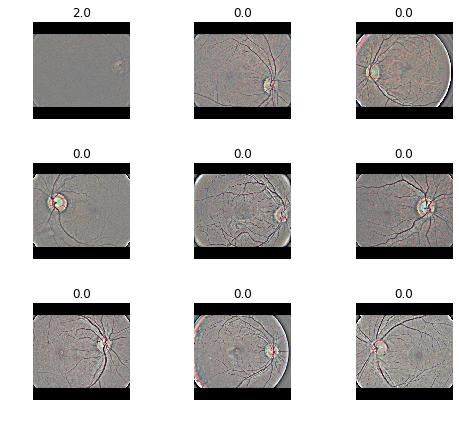

In [27]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [28]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 8.82 ms, sys: 49.1 ms, total: 57.9 ms
Wall time: 1.01 s


In [29]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

# train

In [30]:
learn.freeze()

In [31]:
%%time
learn.lr_find(start_lr=1e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 16.6 s, sys: 7.99 s, total: 24.6 s
Wall time: 5min 14s


In [32]:
!nvidia-smi

Sun Jul 21 02:54:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    42W / 300W |  11423MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Min numerical gradient: 2.29E-02
Min loss divided by 10: 6.03E-03


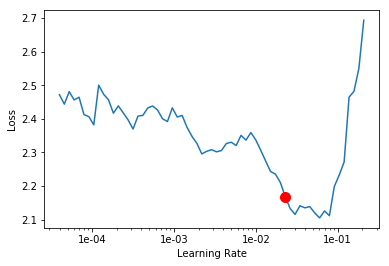

In [33]:
learn.recorder.plot(suggestion=True)

In [34]:
set_torch_seed()
learn.fit_one_cycle(14, max_lr=1e-2, callbacks=[SaveModelCallback(learn, name='bestmodel_frozen')])

epoch,train_loss,valid_loss,time
0,0.977220,1.107705,20:00
1,0.625805,0.716244,18:50
2,0.613754,0.536014,19:49
3,0.540087,0.664175,19:40
4,0.538294,0.714947,18:53
5,0.530303,0.592985,18:56
6,0.487856,0.474614,19:43
7,0.485513,0.509985,20:38
8,0.430703,0.618351,19:52
9,0.406278,0.570404,19:37


Better model found at epoch 0 with valid_loss value: 1.1077046394348145.
Better model found at epoch 1 with valid_loss value: 0.7162439823150635.
Better model found at epoch 2 with valid_loss value: 0.5360140800476074.
Better model found at epoch 6 with valid_loss value: 0.47461381554603577.
Better model found at epoch 13 with valid_loss value: 0.44410452246665955.


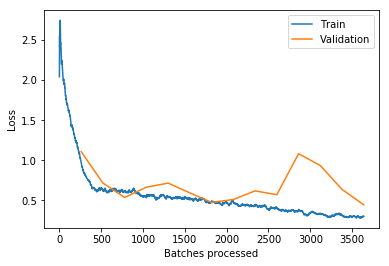

In [35]:
learn.recorder.plot_losses()

In [36]:
learn = learn.load('bestmodel_frozen')

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.10E-07
CPU times: user 19.6 s, sys: 7.78 s, total: 27.4 s
Wall time: 5min 53s


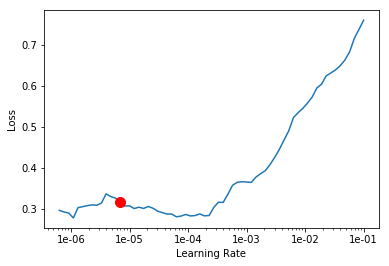

In [38]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [39]:
set_torch_seed()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-5), callbacks=[SaveModelCallback(learn, name='bestmodel_finetune')])

epoch,train_loss,valid_loss,time
0,0.283182,0.489506,19:54
1,0.267060,0.882202,19:27
2,0.290137,0.644037,19:54
3,0.262899,0.446111,20:11
4,0.284067,0.550306,19:06


Better model found at epoch 0 with valid_loss value: 0.48950618505477905.
Better model found at epoch 3 with valid_loss value: 0.44611072540283203.


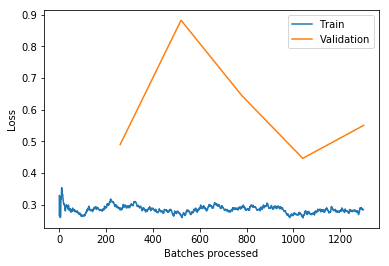

In [40]:
learn.recorder.plot_losses()

In [41]:
!nvidia-smi

Sun Jul 21 09:21:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   50C    P0    57W / 300W |  11571MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# TTTA

In [42]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

# validate and thresholding

In [43]:
learn = learn.load('bestmodel_finetune')

In [44]:
learn = learn.to_fp32()

In [45]:
%%time
set_torch_seed()
preds_val, y_val = learn.TTA(ds_type=DatasetType.Valid)

CPU times: user 1min 22s, sys: 50.4 s, total: 2min 12s
Wall time: 18min 13s


In [46]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [47]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [48]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [49]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [50]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [51]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [52]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 25.4 s, sys: 0 ns, total: 25.4 s
Wall time: 25.4 s


In [53]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.09 s


In [54]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0424511151383118,
  1.6072106276235032,
  2.673374238740953,
  3.4098055619539926],
 'abhishek': array([0.531865, 1.422273, 2.598213, 3.412433])}

In [55]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [56]:
optnm2qwk

{'simple': 0.8594658112959191,
 'hocop1': 0.8674561416713569,
 'abhishek': 0.8646299195056577}

In [57]:
Counter(y_val).most_common()

[(0.0, 1805), (2.0, 999), (1.0, 370), (4.0, 295), (3.0, 193)]

In [58]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [59]:
preds_val_grd.mean()

1.2386673948661933

In [60]:
Counter(preds_val_grd).most_common()

[(0.0, 1663), (2.0, 912), (3.0, 763), (1.0, 291), (4.0, 33)]

In [61]:
list(zip(preds_val_grd, y_val))[:10]

[(2.0, 2.0),
 (3.0, 4.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (3.0, 4.0),
 (0.0, 0.0),
 (3.0, 2.0),
 (2.0, 2.0),
 (1.0, 1.0)]

In [62]:
(preds_val_grd== y_val.squeeze()).mean()

0.6632987438558164

In [63]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [64]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

simple 0.8594658112959191 [0.5, 1.5, 2.5, 3.5]


0    1663
2     912
3     763
1     291
4      33
dtype: int64

hocop1 0.8674561416713569 [1.0424511151383118, 1.6072106276235032, 2.673374238740953, 3.4098055619539926]


0    1850
2    1114
3     512
1     137
4      49
dtype: int64

abhishek 0.8646299195056577 [0.531865 1.422273 2.598213 3.412433]


0    1683
2    1080
3     601
1     249
4      49
dtype: int64

# testing

In [65]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [66]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

CPU times: user 635 ms, sys: 593 ms, total: 1.23 s
Wall time: 11.8 s


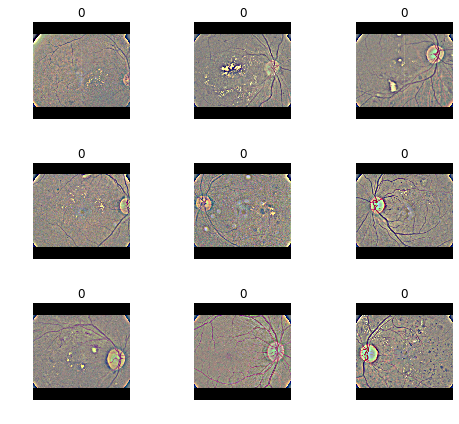

In [67]:
%%time
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Test)

In [68]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 7.17 s, sys: 4.77 s, total: 11.9 s
Wall time: 49.6 s


In [69]:
%%time
set_torch_seed()
preds_tst_tta, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tst_tta = preds_tst_tta.numpy().squeeze()

CPU times: user 43.1 s, sys: 27.8 s, total: 1min 10s
Wall time: 5min 5s


In [70]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [71]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())

simple 0.8594658112959191 [0.5, 1.5, 2.5, 3.5]


2    744
3    656
1    298
0    213
4     17
dtype: int64

hocop1 0.8674561416713569 [1.0424511151383118, 1.6072106276235032, 2.673374238740953, 3.4098055619539926]


2    911
3    434
0    391
1    164
4     28
dtype: int64

abhishek 0.8646299195056577 [0.531865 1.422273 2.598213 3.412433]


2    888
3    531
1    256
0    226
4     27
dtype: int64

In [72]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd_tta = bucket(preds_tst_tta, coef)
    pd.Series(preds_tst_grd_tta.squeeze().astype(int)).value_counts()


In [73]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd = bucket(preds_tst, coef)
    pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


In [74]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


2    744
3    656
1    298
0    213
4     17
dtype: int64

## submit

In [75]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [76]:
subm.diagnosis.value_counts()

2    744
3    656
1    298
0    213
4     17
Name: diagnosis, dtype: int64

In [77]:
subm.to_csv(f"{p_o}/submission.csv", index=False)